In [1]:
import pandas as pd
import numpy as np
import os, yaml

In [2]:
#Read Data
df = pd.read_csv('../heart_statlog_cleveland_hungary_final.csv')

In [4]:
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [5]:
df.columns

Index(['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol',
       'fasting blood sugar', 'resting ecg', 'max heart rate',
       'exercise angina', 'oldpeak', 'ST slope', 'target'],
      dtype='object')

In [6]:
min_value = df['oldpeak'].min()
max_value = df['oldpeak'].max()
print(min_value, max_value)

-2.6 6.2


In [7]:
df['resting ecg'].value_counts()

resting ecg
0    684
2    325
1    181
Name: count, dtype: int64

In [5]:
df['ST slope'].value_counts()

ST slope
2    582
1    526
3     81
0      1
Name: count, dtype: int64

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.logger import logger
from src.utils import *
import sys
from sklearn.model_selection import train_test_split
from dataclasses import dataclass 
import os
from src.exceptions import CustomException


@dataclass
class DataIngetionConfig:

    #Get Directory path of the current script:
    # Get Directory path of the current script:
    current_directory = os.getcwd()    

    #Define artifacts path
    artifact_path = os.path.join(current_directory, "artifacts")

    #Define raw, training and test path
    train_data_path: str = os.path.join(artifact_path, "train.csv")
    test_data_path: str = os.path.join(artifact_path, "test.csv")
    raw_data_path: str = os.path.join(artifact_path, "raw.csv")

class DataIngetion:
    def __init__(self) :
        self.ingetion_config = DataIngetionConfig()

    def inititate_data_ingetion(self):
        """
        This function is used to initiate the data ingetion process.
        """
        logger.info("Initiating data ingetion process...")
        try:
            # Extraction of Data:
            try:
                #Read Data
                df = pd.read_csv('../heart_statlog_cleveland_hungary_final.csv')
            except Exception as e:
                logger.info("Error extracting data from MySQL")
                raise (e)
            finally:
                logger.info("Data read")

            os.makedirs(os.path.dirname(self.ingetion_config.raw_data_path), exist_ok=True)
            
            df.to_csv(self.ingetion_config.raw_data_path, header= True, index=False)
            logger.info("Raw data saved at {}".format(self.ingetion_config.raw_data_path))

            logger.info("Data ingetion process completed...")

            train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
            logger.info("Train data shape: {}".format(train_set.shape))
            logger.info("Test data shape: {}".format(test_set.shape))


            train_data_path = self.ingetion_config.train_data_path
            train_set.to_csv(train_data_path, header= True, index=False)
            logger.info("Train data saved at {}".format(self.ingetion_config.train_data_path))

            test_data_path = self.ingetion_config.test_data_path
            test_set.to_csv(test_data_path, header= True, index=False)
            logger.info("Test data saved at {}".format(self.ingetion_config.test_data_path))

            logger.info("Data Ingetion process completed...")
            
            return train_data_path, test_data_path

        except Exception as e:
            logger.error("Error in data ingetion process")
            raise CustomException(e)

if __name__ == "__main__":
    data_ingetion = DataIngetion()
    data_ingetion.inititate_data_ingetion()

2024-05-07 16:23:35 - HEART_DISEASE_DETECTION_LOG - 3988137006 - INFO : Initiating data ingetion process...
2024-05-07 16:23:35 - HEART_DISEASE_DETECTION_LOG - 3988137006 - INFO : Data read
2024-05-07 16:23:35 - HEART_DISEASE_DETECTION_LOG - 3988137006 - INFO : Raw data saved at c:\Users\abhishdutta\Desktop\PRD Projects\IBM WatsonX\Heart Disease Classification\notebook\artifacts\raw.csv
2024-05-07 16:23:35 - HEART_DISEASE_DETECTION_LOG - 3988137006 - INFO : Data ingetion process completed...
2024-05-07 16:23:35 - HEART_DISEASE_DETECTION_LOG - 3988137006 - INFO : Train data shape: (952, 12)
2024-05-07 16:23:35 - HEART_DISEASE_DETECTION_LOG - 3988137006 - INFO : Test data shape: (238, 12)
2024-05-07 16:23:35 - HEART_DISEASE_DETECTION_LOG - 3988137006 - INFO : Train data saved at c:\Users\abhishdutta\Desktop\PRD Projects\IBM WatsonX\Heart Disease Classification\notebook\artifacts\train.csv
2024-05-07 16:23:35 - HEART_DISEASE_DETECTION_LOG - 3988137006 - INFO : Test data saved at c:\Users\

# Utility Functions

In [1]:
import pickle
def save_objects(file_path, obj):
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(obj, f)
        print("Object saved successfully")
    except Exception as e:
        print("Error in save_objects: {}".format(e))

In [8]:
def outlier_removal(df, num_cols):
    for column in num_cols:
        upper_limit = df[column].mean() + 2 * df[column].std()
        lower_limit = df[column].mean() - 2 * df[column].std()
        df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df

def fill_empty_with_mode(df, cat_cols):
    for i in cat_cols:
        if (df[i] == '').any():
            mode_value = df[i][df[i]!=""].mode().iloc[0]
            df[i] = df[i].replace('',mode_value )
    return df
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def random_search_cv(model, X_train, y_train,params):
    random_cv = RandomizedSearchCV(model, param_distributions=params, scoring="r2", cv = 5, verbose=0 )
    random_cv.fit(X_train, y_train)
    return random_cv, random_cv.best_params_, random_cv.best_score_

In [27]:
#Confusion Matrix

def confusion_matrix_classification_report(y_test, y_pred):
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

    import matplotlib.pyplot as plt
    import seaborn as sns

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    
    #Classification Report
    report = classification_report(y_test, y_pred)
    print(report)

In [33]:

class FeatureClassifier:
    def __init__(self,df, target_column):
        self.df = df
        self.target_column = target_column
    
    def get_ordinal_columns_mapping(self,columns):
        """
        This function is used to get the mapping of ordinal columns.
        Each key is named as 'ColumnName_Map' and contains the unique values for that column.
        """
        columns_mapping = {}
        
        for col in columns:
            sorted_groups = self.df.groupby(col)[self.target_column].mean().sort_values().index.tolist()
            key_name = f"{col}"
            columns_mapping[key_name] = sorted_groups
        
        return columns_mapping
        

        
    def ordinal_onehot_numerical_divide(self):
        """
        This function is used to divide the categorical into ordinal and one-hot columns and numerical columns.
        """
        one_hot_cols = []
        ordinal_cols = []
        num_cols = []
        #Overall mean
        mean = self.df[self.target_column].mean()
        thereshold_percentage = 0.1
        threshold_value = mean * thereshold_percentage
        try:
            for column in self.df.columns:
                if column != self.target_column and self.df[column].dtype == 'object':
                    df_column = self.df[[column, self.target_column]].groupby(column).mean().reset_index()
                    standard_dev = df_column[self.target_column].std()
                    if standard_dev > threshold_value:
                        ordinal_cols.append(column)
                    else:
                        one_hot_cols.append(column)
                else:
                    num_cols.append(column)
            
            print("Outliers removed!!!")

            #Get Mappingsd for ordinal columns:
            ordinal_columns_mapping = self.get_ordinal_columns_mapping(ordinal_cols)
            one_hot_column_mapping = self.get_ordinal_columns_mapping(one_hot_cols)
            return (one_hot_cols, ordinal_cols, num_cols, ordinal_columns_mapping, one_hot_column_mapping)
                 

        except Exception as e:
            print(e)

def save_objects(file_path, obj):
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(obj, f)
        print("Object saved successfully")
    except Exception as e:
        print("Error in save_objects: {}".format(e))
    

def load_obj(file_path):
    try:
        with open(file_path, 'rb') as f:
            obj = pickle.load(f)
        print("Object loaded successfully")
        return obj
    except Exception as e:
        print("Error in load_obj: {}".format(e))
    
from sklearn.metrics import accuracy_score


def random_search_cv(model, X_train, y_train, params):
    random_cv = RandomizedSearchCV(model, param_distributions=params, scoring="accuracy", cv = 5, verbose=0 )
    random_cv.fit(X_train, y_train)
    return random_cv, random_cv.best_params_, random_cv.best_score_

def evaluate_model1(X_train, y_train, X_test, y_test, models):
    report = {}
    
    config_path = "../params.yaml"
    #Load yaml file:x
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
        
    try:
        for i in range(len(models)):
            model = list(models.values())[i]
            model_flag = list(models.keys())[i]
            # model.fit(X_train, y_train)
            
            params = config[model_flag]
            model, model.best_params_, model.best_score_ = random_search_cv(model, X_train, y_train, params)
            
            y_pred = model.predict(X_test)

            test_model_score = accuracy_score(y_test, y_pred)
            print('\n====================================================================================\n')
            print(f"The confusion matrix and classification report for the model: {model_flag} is:")
            confusion_matrix_classification_report(y_test, y_pred)
            print('\n====================================================================================\n')


            print('\n====================================================================================\n')
            print(f"The best parameters for the model{model_flag} are {model.best_params_}")
            print('\n====================================================================================\n')


            report[list(models.keys())[i]] = test_model_score
            print(f"Model: {list(models.keys())[i]}, Accuracy score: {test_model_score}")
        print("Model evaluation complete")
        return report

    except Exception as e:
        print("Error in evaluate_model: {}".format(e))


In [22]:

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

models = {
                'SVC': SVC(),
                'DecisionTree':DecisionTreeClassifier(random_state=42),
                'RandomForest':RandomForestClassifier(random_state=42),
                'GradientBoostingClassification':GradientBoostingClassifier(random_state=42),
                'BaggingClassification' : BaggingClassifier(random_state=42)
            }
config_path = "../params.yaml"
#Load yaml file:x
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    
for i in range(len(models)):
    model = list(models.values())[i]

    model_keys = list(models.keys())[i]
    print(model_keys)
    
    params = config[model_keys]
    print(params)

SVC
{'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2, 3, 4, 5], 'gamma': ['scale', 'auto']}
DecisionTree
{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 28, 29, 20], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
RandomForest
{'n_estimators': [50, 100, 150, 200], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 28, 29, 20], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
GradientBoostingClassification
{'n_estimators': [50, 100, 150, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
BaggingClassification
{'n_estimators': [10, 50, 100], 'max_samples': [0.5, 0.7, 1.0], 'max_features': [0.5, 0.7, 1.0], 'bootstrap': [True, False], 'bootstrap_features': [True, False

In [11]:
config_path = "../params.yaml"
#Load yaml file:x
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    
config["SVC"]


{'C': [0.1, 1, 10, 100],
 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
 'degree': [2, 3, 4, 5],
 'gamma': ['scale', 'auto']}

In [8]:
from src.exceptions import CustomException
# Then you can use your custom exception like this:



# Data Ingetion

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.logger import logger
from src.utils import *
import sys
from sklearn.model_selection import train_test_split
from dataclasses import dataclass 
import os

@dataclass
class DataIngetionConfig:

    #Get Directory path of the current script:
    # Get Directory path of the current script:
    current_directory = os.getcwd()    

    #Define artifacts path
    artifact_path = os.path.join(current_directory, "artifacts")

    #Define raw, training and test path
    train_data_path: str = os.path.join(artifact_path, "train.csv")
    test_data_path: str = os.path.join(artifact_path, "test.csv")
    raw_data_path: str = os.path.join(artifact_path, "raw.csv")

class DataIngetion:
    def __init__(self) :
        self.ingetion_config = DataIngetionConfig()

    def inititate_data_ingetion(self):
        """
        This function is used to initiate the data ingetion process.
        """
        print("Initiating data ingetion process...")
        try:
            # Extraction of Data:
            try:
                #Read Data
                df = pd.read_csv('../heart_statlog_cleveland_hungary_final.csv')
            except Exception as e:
                print("Error extracting data from MySQL")
                raise (e)
            finally:
                print("Data read")

            os.makedirs(os.path.dirname(self.ingetion_config.raw_data_path), exist_ok=True)
            
            df.to_csv(self.ingetion_config.raw_data_path, header= True, index=False)
            print("Raw data saved at {}".format(self.ingetion_config.raw_data_path))

            print("Data ingetion process completed...")

            train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
            print("Train data shape: {}".format(train_set.shape))
            print("Test data shape: {}".format(test_set.shape))


            train_data_path = self.ingetion_config.train_data_path
            train_set.to_csv(train_data_path, header= True, index=False)
            print("Train data saved at {}".format(self.ingetion_config.train_data_path))

            test_data_path = self.ingetion_config.test_data_path
            test_set.to_csv(test_data_path, header= True, index=False)
            print("Test data saved at {}".format(self.ingetion_config.test_data_path))

            print("Data Ingetion process completed...")
            
            return train_data_path, test_data_path

        except Exception as e:
            raise (e)

# if __name__ == "__main__":
#     data_ingetion = DataIngetion()
#     data_ingetion.inititate_data_ingetion()

2024-05-06 17:02:03 - CensusPrediction - logger - INFO : %(levelname)s


# Data Transformation

In [13]:
import os # We use os to create path...
import sys
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer ## HAndling Missing Values
from sklearn.preprocessing import StandardScaler # HAndling Feature Scaling
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder # Ordinal Encoding for categorical variables
## pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer #Group everything together
from dataclasses import dataclass
from src.utils import *
import json

@dataclass

class DataTransformationConfig:
    #Get Directory path of the current script:
    current_directory = os.getcwd()

    #Define artifacts path
    artifact_path = os.path.join(current_directory, "artifacts")

    preprocessor_obj_file_path = os.path.join(artifact_path, "preprocessor_obj.pkl")


class DataTransformation:
    
    def __init__(self) :
        self.data_transformation_config = DataTransformationConfig()

    def get_data_transformation_object(self, categories, one_hot_cols, ordinal_cols, num_cols):
        
        try:
            # Independent numerical columns
            num_cols_list = [num for num in num_cols if num != "target"]
            print("########", num_cols_list)

            # Define pipelines for categorical and numeric data
            categorical_onehot_pipeline = Pipeline([
                
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(sparse_output=False)),
                ('scaler', StandardScaler())
            ])

            categorical_ordinal_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OrdinalEncoder(categories=categories)),
                ('scaler', StandardScaler())
            ])

            numerical_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ])

            # Combine pipelines in a ColumnTransformer
            preprocessor = ColumnTransformer(transformers=[
                ('cat_one_hot', categorical_onehot_pipeline, one_hot_cols),
                ('cat_ordinal', categorical_ordinal_pipeline, ordinal_cols),
                ('num', numerical_pipeline, num_cols_list)
            ])

            print("Pipeline methods creation ends!!!")
            return preprocessor
        
        except Exception as e:
            print("Error in get_data_transformation_object")
            raise (e)
            
    def inititate_data_transformation(self, train_path, test_path):
        try:
            
            print("Initiating data transformation process...")
                
            df_train = pd.read_csv(train_path)
            df_test = pd.read_csv(test_path)
            print("Data loaded successfully")
            
            target_column = "target"
            
            # Number columns:
            num_cols = [col for col in df_train.columns if df_train[col].dtype!= 'object' and col != 'target']
            print("Number columns identified successfully")
        
            #Removal of outliers:
            df_train = outlier_removal(df_train, num_cols)
            print("Outliers removed!!!")

            # Outlier detection:
            df_test = outlier_removal(df_test, num_cols)
            print("Outliers removed!!!")

            # Calling Feature Classifier for training data:
            feature_classifier_obj = FeatureClassifier(df_train,target_column)
            one_hot_cols, ordinal_cols, num_cols, ordinal_columns_mapping, one_hot_column_mapping = feature_classifier_obj.ordinal_onehot_numerical_divide()
            print("Categorical columns  and numerical columns divided successfully")

            df_train = fill_empty_with_mode(df_train,one_hot_cols)
            df_train = fill_empty_with_mode(df_train,ordinal_cols)
            print("Empty values filled with mode successfully")

            df_test = fill_empty_with_mode(df_test,one_hot_cols)
            df_test = fill_empty_with_mode(df_test,ordinal_cols)
            print("Empty values filled with mode successfully")

            
            print(one_hot_cols, ordinal_cols, num_cols, ordinal_columns_mapping, one_hot_column_mapping)
            # Listing all the categories:
            categories = []
            for key, value in ordinal_columns_mapping.items():
                categories.append(value)
            print("Categories created successfully!!!")
            preprocessor_obj = self.get_data_transformation_object(categories, one_hot_cols, ordinal_cols, num_cols)
            
            # Segregation of input and target feature:

            
            X_train = df_train.drop(labels=target_column, axis=1)
            y_train = df_train[target_column]

            X_test = df_test.drop(labels=target_column, axis=1)
            y_test = df_test[target_column]

            print("Input and target feature segregated successfully!!!")
        

            # #Transformation using preprocessing object:
            X_train_arr = preprocessor_obj.fit_transform(X_train)
            print(X_train_arr)
            X_test_arr = preprocessor_obj.transform(X_test)
            print("Preprocessing done successfully!!!")

            train_arr = np.c_[X_train_arr, np.array(y_train)]
            test_arr = np.c_[X_test_arr, np.array(y_test)]

            print("Data transformation done successfully!!!")

            categorical_column_mapping = ordinal_columns_mapping | one_hot_column_mapping

            #Saving ordinal_columns_mapping into ordinal_columns_mapping.json for app.py use:
            categorical_column_mapping_path = os.path.join(self.data_transformation_config.current_directory, "categorical_column_mapping.json")
            with open(categorical_column_mapping_path, 'w') as f:
                json.dump(categorical_column_mapping, f)

            print("ordinal_columns_mapping.json created successfully!!!")

            
            #Saving the Pickle file preprocessing object:
            save_objects(
                file_path = self.data_transformation_config.preprocessor_obj_file_path,
                obj = preprocessor_obj
            )
            print(f"Saved the Pickle file preprocessing object to: {self.data_transformation_config.preprocessor_obj_file_path}" )
            
            return train_arr, test_arr, self.data_transformation_config.preprocessor_obj_file_path

        except Exception as e:
            print("Error occured while initiating the data transformation process: {}".format(e))


# Model Training

In [14]:


from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier


from dataclasses import dataclass
import yaml



@dataclass
class ModelTrainerConfig:

    # Get Directory path of the current script:
    current_directory = os.getcwd()

    # Define artifacts path
    artifact_path = os.path.join(current_directory, "artifacts")

    #Define model.pkl path:
    trained_model_path = os.path.join(artifact_path, "model.pkl")
    
class InitiateModelTraining:
    def __init__(self) :
        self.model_trainer_config = ModelTrainerConfig()

    def initiate_model_training(self, train_array, test_array):
        """
        This function is used to initiate the model training process.
        """
        print("Initiating model training process...")
        try:
            X_train, y_train, X_test, y_test = (
                train_array[:,:-1],
                train_array[:,-1],
                test_array[:,:-1],
                test_array[:,-1]
                )

            models = {
                'SVC': SVC(),
                'DecisionTree':DecisionTreeClassifier(random_state=42),
                'RandomForest':RandomForestClassifier(random_state=42),
                'GradientBoostingClassification':GradientBoostingClassifier(random_state=42),
                'BaggingClassification' : BaggingClassifier(random_state=42)
            }

            model_report: dict = evaluate_model1(X_train, y_train, X_test, y_test, models=models)

            print('\n====================================================================================\n')
            print(f'Model Report : {model_report}')
            print('\n====================================================================================\n')

            best_model_score = max(sorted(model_report.values()))
            best_model_name = list(model_report.keys())[list(model_report.values()).index(best_model_score)]
            
            print('\n====================================================================================\n')
            print(f'Best Model: {best_model_name} ## Best Model Score : {best_model_score}')
            print('\n====================================================================================\n')

            best_model = models[best_model_name]

            #Save object:
            save_objects(self.model_trainer_config.trained_model_path, best_model)
        except Exception as e:
            print("Error initiating model training process", e)


In [15]:
data_ingetion_obj = DataIngetion()
train_data_path, test_data_path = data_ingetion_obj.inititate_data_ingetion()


Initiating data ingetion process...
Data read
Raw data saved at c:\Users\abhishdutta\Desktop\PRD Projects\IBM WatsonX\Heart Disease\Notebook\artifacts\raw.csv
Data ingetion process completed...
Train data shape: (952, 12)
Test data shape: (238, 12)
Train data saved at c:\Users\abhishdutta\Desktop\PRD Projects\IBM WatsonX\Heart Disease\Notebook\artifacts\train.csv
Test data saved at c:\Users\abhishdutta\Desktop\PRD Projects\IBM WatsonX\Heart Disease\Notebook\artifacts\test.csv
Data Ingetion process completed...


In [16]:

train_data_path


'c:\\Users\\abhishdutta\\Desktop\\PRD Projects\\IBM WatsonX\\Heart Disease\\Notebook\\artifacts\\train.csv'

In [31]:
data_transformation_obj = DataTransformation()

train_arr, test_arr, preprocessor_path = data_transformation_obj.inititate_data_transformation(train_data_path, test_data_path)




Initiating data transformation process...
Data loaded successfully
Number columns identified successfully
Outliers removed!!!
Outliers removed!!!
Outliers removed!!!
Categorical columns  and numerical columns divided successfully
Empty values filled with mode successfully
Empty values filled with mode successfully
[] [] ['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope', 'target'] {} {}
Categories created successfully!!!
######## ['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope']
Pipeline methods creation ends!!!
Input and target feature segregated successfully!!!
[[ 0.45007035 -1.52819039  0.90448464 ...  1.45798295  1.37268765
   1.07403133]
 [ 0.45007035  0.65436873 -1.52673452 ... -0.68587908 -0.83128929
  -0.93107153]
 [-1.2893678  -1.52819039 -1.52673452 ... -0

Initiating model training process...


The confusion matrix and classification report for the model: SVC is:
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91        77
         1.0       0.88      0.94      0.91        71

    accuracy                           0.91       148
   macro avg       0.91      0.91      0.91       148
weighted avg       0.91      0.91      0.91       148





The best parameters for the modelSVC are {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 10}


Model: SVC, Accuracy score: 0.9121621621621622


The confusion matrix and classification report for the model: DecisionTree is:
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87        77
         1.0       0.87      0.83      0.85        71

    accuracy                           0.86       148
   macro avg       0.86      0.86      0.86       148
weighted avg       0.86      0.86      0.86       148







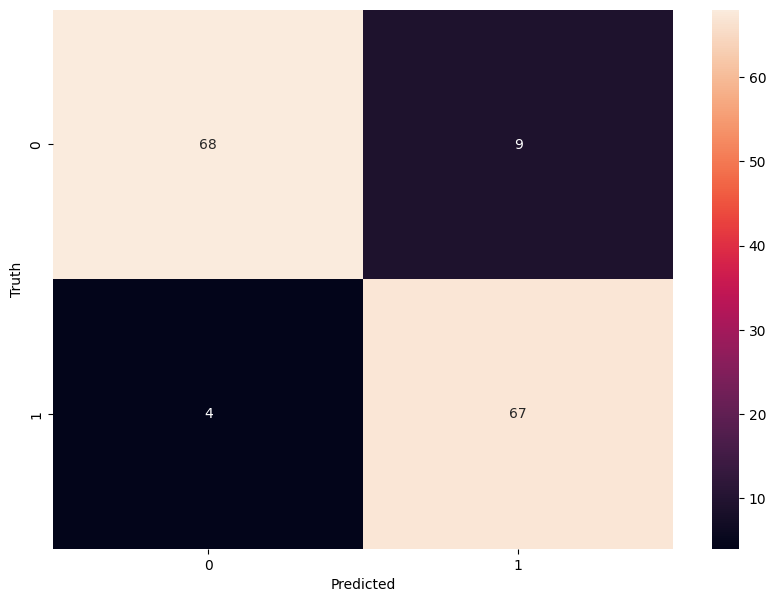

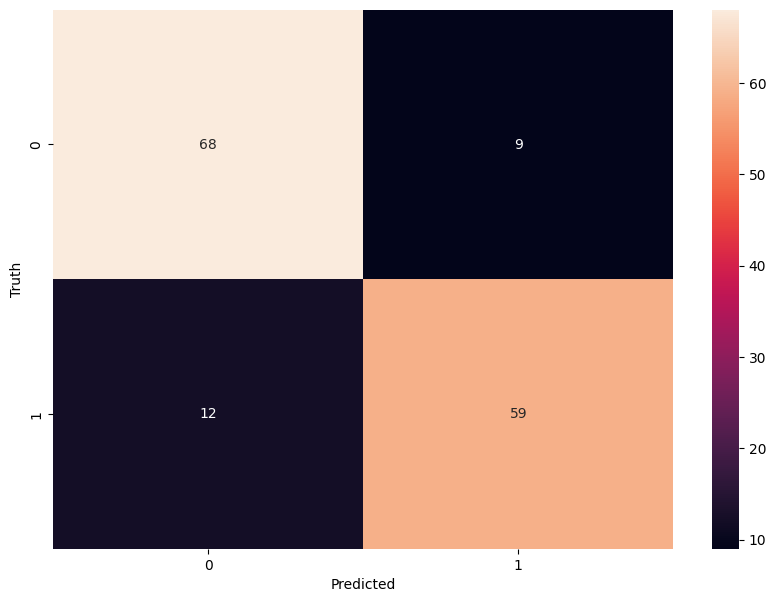

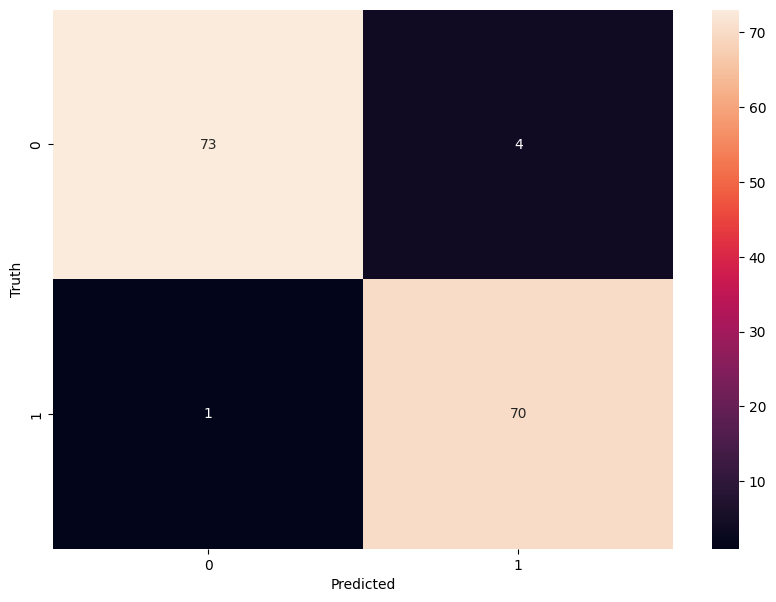

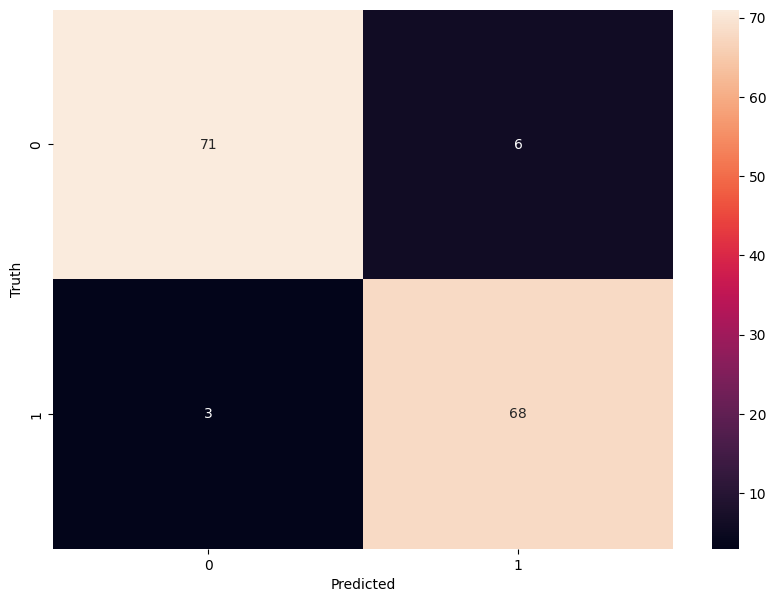

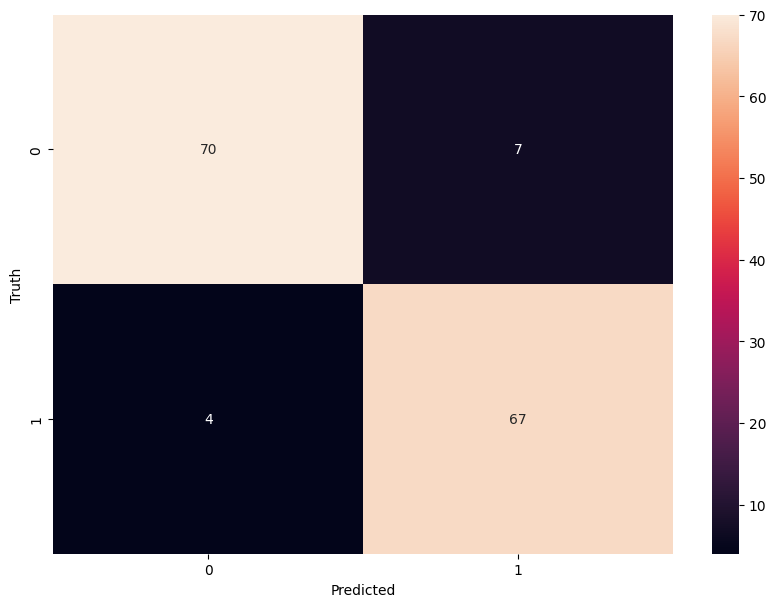

In [34]:
model_trainer_obj = InitiateModelTraining()
model_trainer_obj.initiate_model_training(train_arr, test_arr)

In [23]:
from src.utils import *
model = load_obj(os.path.join("artifacts", "model.pkl"))
print(model)

2024-05-07 18:18:53 - HEART_DISEASE_DETECTION_LOG - utils - INFO : Error in load_obj: [Errno 2] No such file or directory: 'artifacts\\model.pkl'


None


In [24]:
data = {
    "age": 21,
    "sex": 1,
    "chest pain type": 0,
    "resting bp s": 123,
    "cholesterol": 220,
    "fasting blood sugar": 1,
    "resting ecg": 1,
    "max heart rate": 87,
    "exercise angina": 2,
    "oldpeak": 1,
    "ST slope": 1,
}

data_df = pd.DataFrame(data=data, index=[0])
print(data_df)

   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   21    1                0           123          220                    1   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  
0            1              87                2        1         1  


In [25]:
os.path.join("artifacts", "preprocessor_obj.pkl")

'artifacts\\preprocessor_obj.pkl'

In [31]:
preprocessor = load_obj("C:/Users/abhishdutta/Desktop/PRD Projects/IBM WatsonX/Heart Disease Classification/artifacts/preprocessor_obj.pkl")
preprocessor

2024-05-07 18:28:24 - HEART_DISEASE_DETECTION_LOG - utils - INFO : Object loaded successfully


ColumnTransformer(transformers=[('cat_one_hot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False)),
                                                 ('scaler', StandardScaler())]),
                                 []),
                                ('cat_ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OrdinalEncoder(categories=[])),
                                                 ('scaler', StandardScaler())]),
                                 []),
                                ('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'sex', 'chest pain type',
                                  'resting bp s', 'cholesterol',
                                  'fasting blood sugar', 'resting ecg',
                                  'max heart rate', 'exercise angina',
                                  'oldpeak', 'ST slope'])])

In [27]:
model = load_obj("C:/Users/abhishdutta/Desktop/PRD Projects/IBM WatsonX/Heart Disease Classification/artifacts/model.pkl")
model

2024-05-07 18:19:06 - HEART_DISEASE_DETECTION_LOG - utils - INFO : Object loaded successfully


BaggingClassifier(random_state=42)

In [32]:
new_data = preprocessor.transform(data_df)



In [33]:
new_data

array([[-3.60861867,  0.65436873, -3.95795369, -0.45612769, -0.44133614,
         1.        ,  0.38023184, -2.52683549,  3.60184498,  0.32869857,
        -0.93107153]])

In [35]:
prediction = model.predict(new_data)

NotFittedError: This BaggingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Debugging

In [36]:
df

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,45,1,1,110,264,0,0,132,0,1.2,2,1
1186,68,1,4,144,193,1,0,141,0,3.4,2,1
1187,57,1,4,130,131,0,0,115,1,1.2,2,1
1188,57,0,2,130,236,0,2,174,0,0.0,2,1


In [3]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
target_column = "target"
X_train = df_train.drop(labels=target_column, axis=1)
y_train = df_train[target_column]

X_test = df_test.drop(labels=target_column, axis=1)
y_test = df_test[target_column]

In [5]:
y_train

1005    1
224     0
798     1
816     1
427     0
       ..
1044    1
1095    0
1130    1
860     1
1126    0
Name: target, Length: 952, dtype: int64

In [13]:
from src.logger import logger
from src.utils import *
# Number columns:
num_cols = [col for col in df_train.columns if df_train[col].dtype!= 'object' and col != 'target']
logger.info("Number columns identified successfully")

#Removal of outliers:
df_train = outlier_removal(df_train, num_cols)
logger.info("Outliers removed!!!")

# Outlier detection:
df_test = outlier_removal(df_test, num_cols)
logger.info("Outliers removed!!!")

# Calling Feature Classifier for training data:
feature_classifier_obj = FeatureClassifier(df_train,target_column)
one_hot_cols, ordinal_cols, num_cols, ordinal_columns_mapping, one_hot_column_mapping = feature_classifier_obj.ordinal_onehot_numerical_divide()
logger.info("Categorical columns  and numerical columns divided successfully")

2024-05-07 19:33:26 - HEART_DISEASE_DETECTION_LOG - 3385840026 - INFO : Number columns identified successfully
2024-05-07 19:33:26 - HEART_DISEASE_DETECTION_LOG - 3385840026 - INFO : Outliers removed!!!
2024-05-07 19:33:26 - HEART_DISEASE_DETECTION_LOG - 3385840026 - INFO : Outliers removed!!!
2024-05-07 19:33:26 - HEART_DISEASE_DETECTION_LOG - utils - INFO : Outliers removed!!!
2024-05-07 19:33:26 - HEART_DISEASE_DETECTION_LOG - 3385840026 - INFO : Categorical columns  and numerical columns divided successfully


In [14]:
class DataTransformation:
    

    def get_data_transformation_object(self, categories, one_hot_cols, ordinal_cols, num_cols):
        
        try:
            # Independent numerical columns
            num_cols_list = [num for num in num_cols if num != "target"]  ##It can be automated via taking from UI
            logger.info("numerical columns %s", num_cols_list)

            # Define pipelines for categorical and numeric data
            categorical_onehot_pipeline = Pipeline([
                
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(sparse_output=False)),
                ('scaler', StandardScaler())
            ])

            categorical_ordinal_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OrdinalEncoder(categories=categories)),
                ('scaler', StandardScaler())
            ])

            numerical_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ])

            # Combine pipelines in a ColumnTransformer
            preprocessor = ColumnTransformer(transformers=[
                ('cat_one_hot', categorical_onehot_pipeline, one_hot_cols),
                ('cat_ordinal', categorical_ordinal_pipeline, ordinal_cols),
                ('num', numerical_pipeline, num_cols_list)
            ])

            logger.info("Pipeline methods creation ends!!!")
            return preprocessor
        
        except Exception as e:
            logger.error("Error in get_data_transformation_object")
            raise CustomException(e)

In [15]:
## pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer #Group everything together
from sklearn.impute import SimpleImputer ## HAndling Missing Values
from sklearn.preprocessing import StandardScaler # HAndling Feature Scaling
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from src.components.data_transformation import DataTransformation

categories = []
# for key, value in ordinal_columns_mapping.items():
#     categories.append(value)
# logger.info("Categories created successfully!!!")
obj = DataTransformation()
preprocessor_obj = obj.get_data_transformation_object(categories, one_hot_cols, ordinal_cols, num_cols)
preprocessor_obj

2024-05-07 19:33:30 - HEART_DISEASE_DETECTION_LOG - data_transformation - INFO : Numerical Column ['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope']
2024-05-07 19:33:30 - HEART_DISEASE_DETECTION_LOG - data_transformation - INFO : Pipeline methods creation ends!!!


ColumnTransformer(transformers=[('cat_one_hot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False)),
                                                 ('scaler', StandardScaler())]),
                                 []),
                                ('cat_ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OrdinalEncoder(categories=[])),
                                                 ('scaler', StandardScaler())]),
                                 []),
                                ('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'sex', 'chest pain type',
                                  'resting bp s', 'cholesterol',
                                  'fasting blood sugar', 'resting ecg',
                                  'max heart rate', 'exercise angina',
                                  'oldpeak', 'ST slope'])])

In [16]:
X_train = df_train.drop(labels=target_column, axis=1)
y_train = df_train[target_column]

X_test = df_test.drop(labels=target_column, axis=1)
y_test = df_test[target_column]



In [17]:
# #Transformation using preprocessing object:
X_train_arr = preprocessor_obj.fit_transform(X_train)
logger.info(X_train_arr)
X_test_arr = preprocessor_obj.transform(X_test)

2024-05-07 19:33:34 - HEART_DISEASE_DETECTION_LOG - 3200642975 - INFO : [[ 0.45007035 -1.52819039  0.90448464 ...  1.45798295  1.37268765
   1.07403133]
 [ 0.45007035  0.65436873 -1.52673452 ... -0.68587908 -0.83128929
  -0.93107153]
 [-1.2893678  -1.52819039 -1.52673452 ... -0.68587908  0.79269372
  -0.93107153]
 ...
 [ 0.68199543  0.65436873  0.90448464 ... -0.68587908 -0.83128929
  -0.93107153]
 [ 0.3341078   0.65436873 -1.52673452 ... -0.68587908 -0.83128929
  -0.93107153]
 [-1.17340526  0.65436873 -1.52673452 ... -0.68587908 -0.83128929
  -0.93107153]]


In [18]:
train_arr = np.c_[X_train_arr, np.array(y_train)]
test_arr = np.c_[X_test_arr, np.array(y_test)]

2024-05-07 19:33:52 - HEART_DISEASE_DETECTION_LOG - utils - INFO : 

2024-05-07 19:33:52 - HEART_DISEASE_DETECTION_LOG - utils - INFO : The confusion matrix and classification report for the model: SVC is:
2024-05-07 19:33:52 - HEART_DISEASE_DETECTION_LOG - utils - INFO :               precision    recall  f1-score   support

         0.0       0.89      0.95      0.92        77
         1.0       0.94      0.87      0.91        71

    accuracy                           0.91       148
   macro avg       0.91      0.91      0.91       148
weighted avg       0.91      0.91      0.91       148

2024-05-07 19:33:52 - HEART_DISEASE_DETECTION_LOG - utils - INFO : 

2024-05-07 19:33:52 - HEART_DISEASE_DETECTION_LOG - utils - INFO : 

2024-05-07 19:33:52 - HEART_DISEASE_DETECTION_LOG - utils - INFO : The best parameters for the modelSVC are {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 10}
2024-05-07 19:33:52 - HEART_DISEASE_DETECTION_LOG - utils - INFO : 

2024-05-07 19:33:52 - HEAR

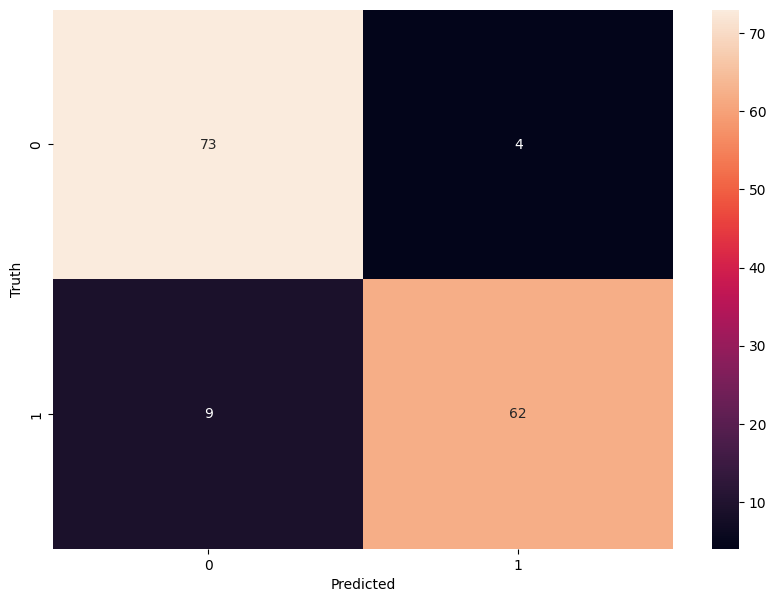

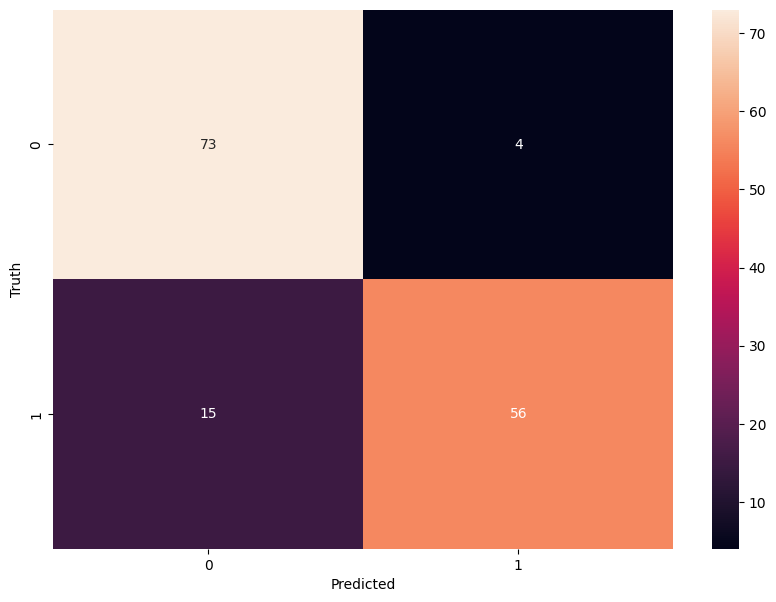

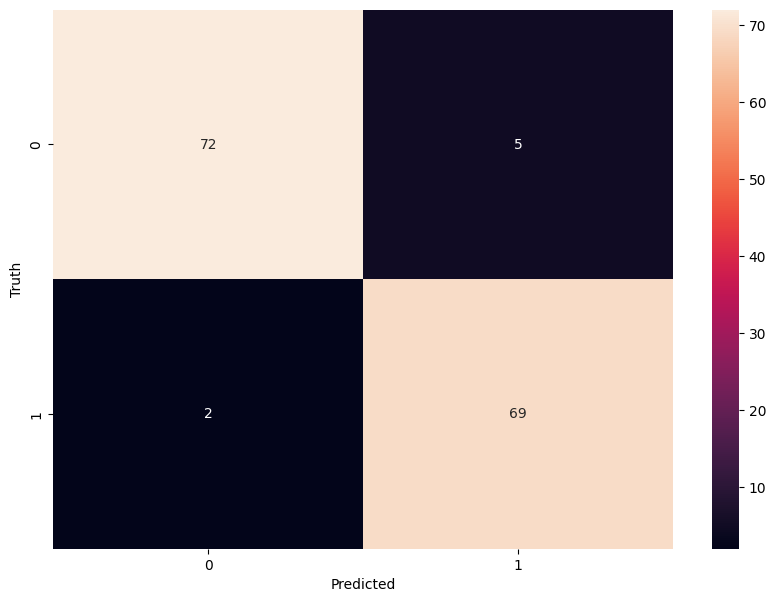

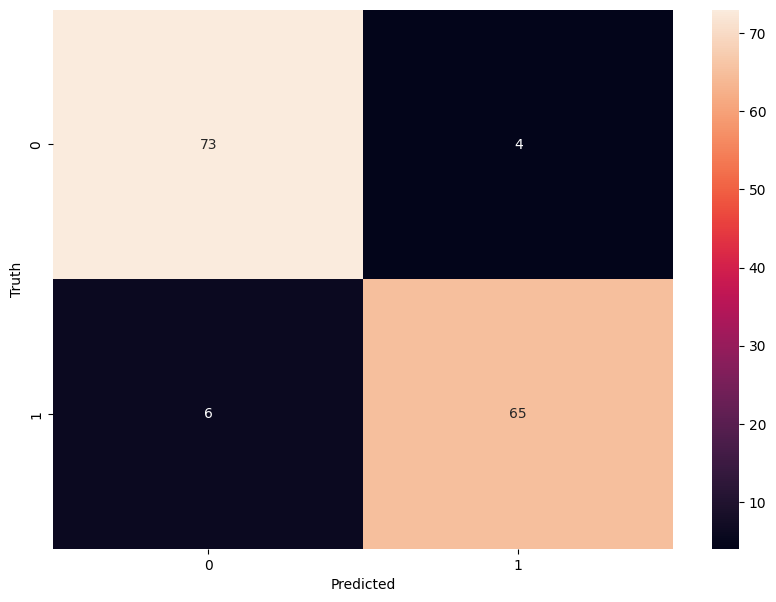

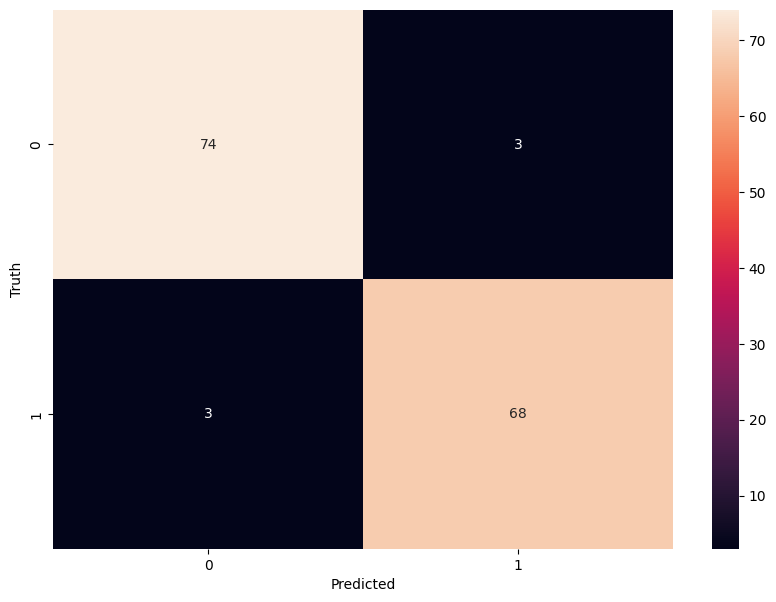

In [19]:
import os
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from src.logger import logger
from src.exceptions import CustomException
X_train, y_train, X_test, y_test = (
    train_arr[:,:-1],
    train_arr[:,-1],
    test_arr[:,:-1],
    test_arr[:,-1]
    )

models = {
    'SVC': SVC(),
    'DecisionTree':DecisionTreeClassifier(random_state=42),
    'RandomForest':RandomForestClassifier(random_state=42),
    'GradientBoostingClassification':GradientBoostingClassifier(random_state=42),
    'BaggingClassification' : BaggingClassifier(random_state=42)
}

model_report: dict = evaluate_model(X_train, y_train, X_test, y_test, models=models)


In [20]:
model_report

{'SVC': {'score': 0.9121621621621622,
  'best_params': {'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'C': 10}},
 'DecisionTree': {'score': 0.8716216216216216,
  'best_params': {'min_samples_split': 8,
   'min_samples_leaf': 2,
   'max_depth': 17}},
 'RandomForest': {'score': 0.9527027027027027,
  'best_params': {'n_estimators': 150,
   'min_samples_split': 4,
   'min_samples_leaf': 1,
   'max_depth': 17}},
 'GradientBoostingClassification': {'score': 0.9324324324324325,
  'best_params': {'n_estimators': 100,
   'min_samples_split': 10,
   'min_samples_leaf': 5,
   'max_depth': 8,
   'learning_rate': 0.2}},
 'BaggingClassification': {'score': 0.9594594594594594,
  'best_params': {'n_estimators': 50,
   'max_samples': 0.7,
   'max_features': 0.7,
   'bootstrap_features': False,
   'bootstrap': True}}}

In [21]:
# Get the model names and their scores
model_scores = {model_name: model_info['score'] for model_name, model_info in model_report.items()}
model_scores

{'SVC': 0.9121621621621622,
 'DecisionTree': 0.8716216216216216,
 'RandomForest': 0.9527027027027027,
 'GradientBoostingClassification': 0.9324324324324325,
 'BaggingClassification': 0.9594594594594594}

In [23]:
# Find the model with the best score
best_model_name = max(model_scores, key=model_scores.get)
best_model_score = model_scores[best_model_name]
print(best_model_name, best_model_score)

BaggingClassification 0.9594594594594594


In [24]:



# Get the best parameters for the best model
best_model_params = model_report[best_model_name]['best_params']
best_model = models[best_model_name]
print(best_model_name, best_model_params)

BaggingClassification {'n_estimators': 50, 'max_samples': 0.7, 'max_features': 0.7, 'bootstrap_features': False, 'bootstrap': True}


In [25]:
models[best_model_name]

BaggingClassifier(random_state=42)

In [26]:
# Create a new instance of the model using the best parameters
best_model = models[best_model_name].set_params(**best_model_params)

# Fit the model with the best parameters
best_model.fit(X_train, y_train)


BaggingClassifier(max_features=0.7, max_samples=0.7, n_estimators=50,
                  random_state=42)

In [59]:
logger.info('\n====================================================================================\n')
logger.info(f'Model Report : {model_report}')
logger.info('\n====================================================================================\n')



2024-05-07 18:45:06 - HEART_DISEASE_DETECTION_LOG - 1915994852 - INFO : 

2024-05-07 18:45:06 - HEART_DISEASE_DETECTION_LOG - 1915994852 - INFO : Model Report : {'SVC': 0.9121621621621622, 'DecisionTree': 0.8851351351351351, 'RandomForest': 0.9391891891891891, 'GradientBoostingClassification': 0.9324324324324325, 'BaggingClassification': 0.9391891891891891}
2024-05-07 18:45:06 - HEART_DISEASE_DETECTION_LOG - 1915994852 - INFO : 



In [60]:
best_model_score = max(sorted(model_report.values()))
best_model_name = list(model_report.keys())[list(model_report.values()).index(best_model_score)]
best_model_name



'RandomForest'

In [61]:
logger.info('\n====================================================================================\n')
logger.info(f'Best Model: {best_model_name} ## Best Model Score : {best_model_score}')
logger.info('\n====================================================================================\n')

best_model = models[best_model_name]

2024-05-07 18:45:43 - HEART_DISEASE_DETECTION_LOG - 4186424821 - INFO : 

2024-05-07 18:45:43 - HEART_DISEASE_DETECTION_LOG - 4186424821 - INFO : Best Model: RandomForest ## Best Model Score : 0.9391891891891891
2024-05-07 18:45:43 - HEART_DISEASE_DETECTION_LOG - 4186424821 - INFO : 



In [62]:
best_model

RandomForestClassifier(random_state=42)

In [27]:
data = {
    "age": 21,
    "sex": 1,
    "chest pain type": 0,
    "resting bp s": 123,
    "cholesterol": 220,
    "fasting blood sugar": 1,
    "resting ecg": 1,
    "max heart rate": 87,
    "exercise angina": 2,
    "oldpeak": 1,
    "ST slope": 1,
}

data_df = pd.DataFrame(data=data, index=[0])
print(data_df)

   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   21    1                0           123          220                    1   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  
0            1              87                2        1         1  


In [28]:
new_data = preprocessor_obj.transform(data_df)
new_data

array([[-3.60861867,  0.65436873, -3.95795369, -0.45612769, -0.44133614,
         1.        ,  0.38023184, -2.52683549,  3.60184498,  0.32869857,
        -0.93107153]])

In [29]:
best_model.predict(new_data)

array([0.])

In [68]:
new_data_arr = np.c_[new_data]
new_data_arr

array([[-3.60861867,  0.65436873, -3.95795369, -0.45612769, -0.44133614,
         1.        ,  0.38023184, -2.52683549,  3.60184498,  0.32869857,
        -0.93107153]])

In [80]:
X_train[0]

array([ 0.45007035, -1.52819039,  0.90448464,  0.31480498,  3.32013573,
        0.        ,  1.51059499,  0.24086135,  1.45798295,  1.37268765,
        1.07403133])

In [77]:
all_except_last = train_arr[:-1]


In [81]:
best_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [82]:
predict = best_model.predict(new_data_arr)

In [83]:
predict

array([0.])